In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/btc-min/BTCUSD_1m_BitMEX.csv
/kaggle/input/btc-min/BTCUSD_1m_Coinbase.csv
/kaggle/input/btc-min/BTCUSD_1m_Binance.csv
/kaggle/input/btc-min/BTCUSD_1m_KuCoin.csv
/kaggle/input/btc-min/BTCUSD_1m_Bitfinex.csv
/kaggle/input/btc-min/BTCUSD_1m_Bitstamp.csv
/kaggle/input/btc-min/BTCUSD_1m_BinanceFutures.csv
/kaggle/input/btc-min/BTCUSD_1m_Combined_Index.csv
/kaggle/input/btc-min/BTCUSD_1m_OKX.csv


In [83]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [84]:
# Download Bitcoin data using yfinance (last 5 years)
btc_data = yf.download('BTC-USD', start='2023-07-17', end='2025-07-17')

# Select the closing price
btc_data = btc_data[['Close']].dropna()

# Scale only the Close column
from sklearn.preprocessing import MinMaxScaler

# Scale only the Close column separately
close_scaler = MinMaxScaler()
btc_data['Close_scaled'] = close_scaler.fit_transform(btc_data[['Close']])


# Check the first 5 rows of the data
print(btc_data.tail())

/tmp/ipykernel_36/4079083437.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_data = yf.download('BTC-USD', start='2023-07-17', end='2025-07-17')
[*********************100%***********************]  1 of 1 completed

Price               Close Close_scaled
Ticker            BTC-USD             
Date                                  
2025-07-12  117435.226562     0.974500
2025-07-13  119116.117188     0.992253
2025-07-14  119849.703125     1.000000
2025-07-15  117777.187500     0.978112
2025-07-16  118738.507812     0.988265


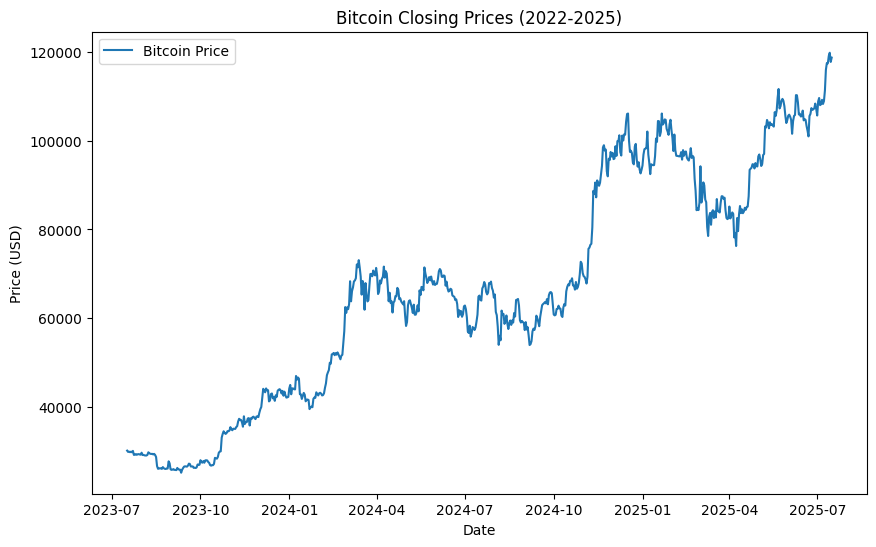

In [85]:
# Visualize Bitcoin closing prices
plt.figure(figsize=(10, 6))
plt.plot(btc_data['Close'], label='Bitcoin Price')
plt.title('Bitcoin Closing Prices (2022-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [86]:
# Scale the data between 0 and 1
scaler = MinMaxScaler()
scaled_data = btc_data[['Close_scaled']].values

# Split train and test
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

train_data.shape, test_data.shape

((584, 1), (147, 1))

In [87]:
# Prepare the input (X) and output (y) for LSTM
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, :])    # Use all features
        y.append(data[i, 0])                # Predict closing price
    return np.array(X), np.array(y)

time_step = 60  # We will use the last 60 days for prediction
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((524, 60, 1), (524,), (87, 60, 1), (87,))

In [88]:
# Build the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # We will output a single prediction value

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.1236 - val_loss: 0.0416
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0106 - val_loss: 0.0020
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0032 - val_loss: 0.0053
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

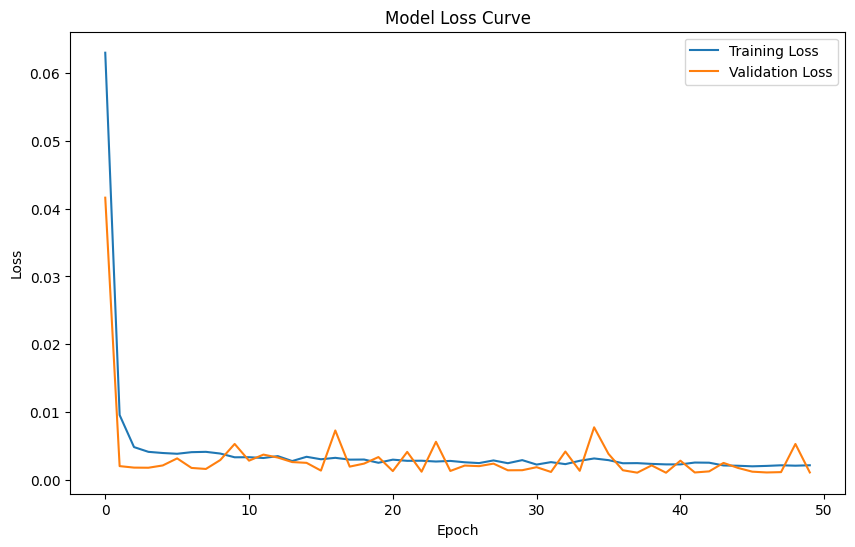

In [89]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Visualize the loss during the training process
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step
MAE (%): 2.69%
RMSE (%): 3.49%
MAPE: 2.27%
Accuracy: 97.73%


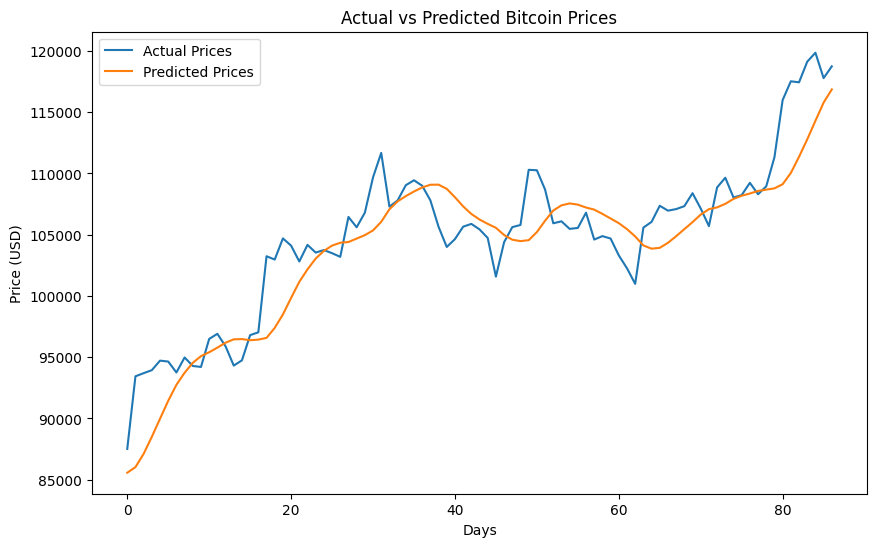

In [90]:
# Make predictions using the test data
predictions = model.predict(X_test)
predictions = close_scaler.inverse_transform(predictions) #Reverse scale only the Close column

# Visualize the real vs predicted prices
y_test_actual = close_scaler.inverse_transform(y_test.reshape(-1, 1))


from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# MAE, RMSE, MSE already calculated:
# mae = ...
# rmse = ...
# mse = ...

# Mean of actual test values
mean_actual = np.mean(y_test_actual)

# Calculate percentage errors
mae_percent = (mae / mean_actual) * 100
rmse_percent = (rmse / mean_actual) * 100

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
accuracy = 100 - mape

# Print results
print(f"MAE (%): {mae_percent:.2f}%")
print(f"RMSE (%): {rmse_percent:.2f}%")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.title('Actual vs Predicted Bitcoin Prices')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

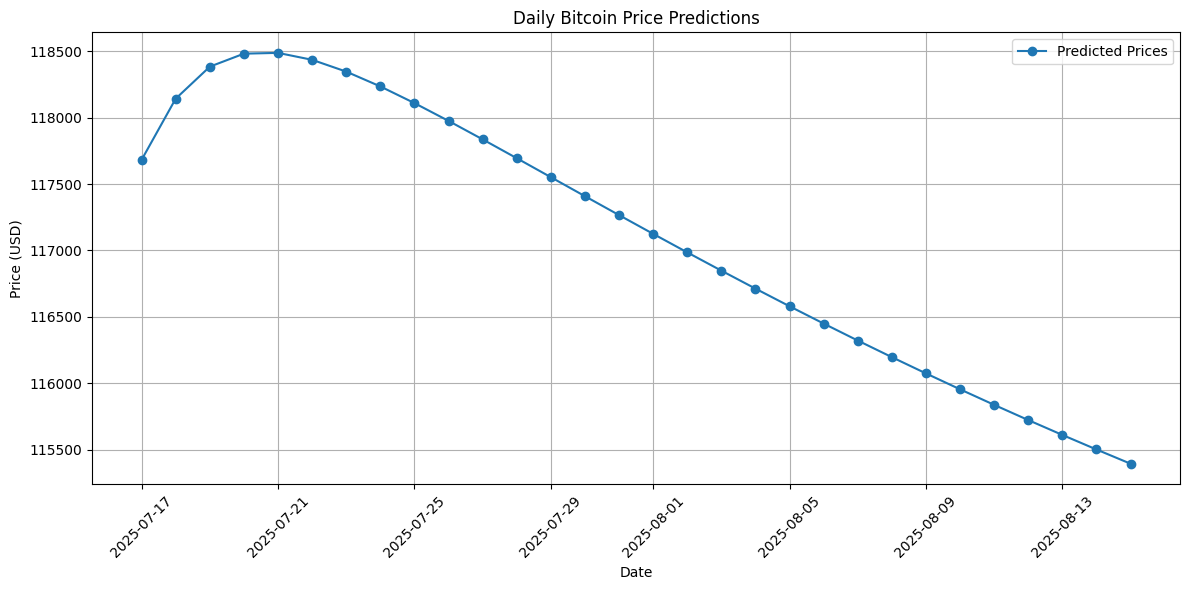

         Date  Predicted Price (USD)
0  2025-07-17          117682.242188
1  2025-07-18          118142.718750
2  2025-07-19          118383.640625
3  2025-07-20          118481.476562
4  2025-07-21          118487.445312
5  2025-07-22          118435.218750
6  2025-07-23          118346.484375
7  2025-07-24          118235.007812
8  2025-07-25          118109.539062
9  2025-07-26          117975.531250
10 2025-07-27          117836.515625
11 2025-07-28          117694.796875
12 2025-07-29          117551.882812
13 2025-07-30          117408.859375
14 2025-07-31          117266.500000
15 2025-08-01          117125.375000
16 2025-08-02          116985.882812
17 2025-08-03          116848.398438
18 2025-08-04          116713.148438
19 2025-08-05          116580.320312
20 2025-08-06          116450.023438
21 2025-08-07          116322.351562
22 2025-08-08          116197.320312
23 2025-08-09          116074.984375
24 2025-08-10          115955.281250
25 2025-08-11          115838.218750
2

In [91]:
# Assume you already have hourly closing prices in `btc_hourly`

# Normalize
scaled_data = btc_data[['Close_scaled']].values

# Last 60 hours for prediction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

# Predict next 30 days instead of 12 months
future_days = 30
future_data = scaled_data[-time_step:].reshape(1, time_step, 1)

future_predictions = []

for _ in range(future_days):
    pred = model.predict(future_data, verbose=0)
    future_predictions.append(pred[0][0])
    
    # Prepare the next input
    next_input = np.append(future_data[:, 1:, :], [[[pred[0][0]]]], axis=1)
    future_data = next_input

# Reverse scaling
future_predictions = close_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates starting from the last date in your dataset
last_date = pd.to_datetime(btc_data.index[-1])  # Use your original DataFrame's index
future_dates = [last_date + timedelta(days=i) for i in range(1, future_days + 1)]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, marker='o', label='Predicted Prices')
plt.title('Daily Bitcoin Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Show prediction table
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Price (USD)': future_predictions.flatten()})
print(future_df)

In [92]:
# --- Buy/Sell/TP/SL Logic ---

# Parameters
take_profit_pct = 0.05  # 5% Take Profit
stop_loss_pct = 0.03    # 3% Stop Loss

# Add column for trading signals
future_df['Signal'] = 'Hold'

# Trading logic
in_position = False
buy_price = 0

for i in range(len(future_df) - 1):
    today = future_df.iloc[i]
    tomorrow = future_df.iloc[i + 1]

    # Generate a Buy signal
    if not in_position and tomorrow['Predicted Price (USD)'] > today['Predicted Price (USD)']:
        future_df.at[i, 'Signal'] = 'Buy'
        buy_price = today['Predicted Price (USD)']
        in_position = True

    # Already in a position - check TP or SL
    elif in_position:
        current_price = today['Predicted Price (USD)']
        change_pct = (current_price - buy_price) / buy_price

        if change_pct >= take_profit_pct:
            future_df.at[i, 'Signal'] = 'Sell (TP)'
            in_position = False
        elif change_pct <= -stop_loss_pct:
            future_df.at[i, 'Signal'] = 'Sell (SL)'
            in_position = False

# Final day: close position if still open
if in_position:
    future_df.at[len(future_df) - 1, 'Signal'] = 'Sell (End)'

# Print updated table with signals
print(future_df)

         Date  Predicted Price (USD)      Signal
0  2025-07-17          117682.242188         Buy
1  2025-07-18          118142.718750        Hold
2  2025-07-19          118383.640625        Hold
3  2025-07-20          118481.476562        Hold
4  2025-07-21          118487.445312        Hold
5  2025-07-22          118435.218750        Hold
6  2025-07-23          118346.484375        Hold
7  2025-07-24          118235.007812        Hold
8  2025-07-25          118109.539062        Hold
9  2025-07-26          117975.531250        Hold
10 2025-07-27          117836.515625        Hold
11 2025-07-28          117694.796875        Hold
12 2025-07-29          117551.882812        Hold
13 2025-07-30          117408.859375        Hold
14 2025-07-31          117266.500000        Hold
15 2025-08-01          117125.375000        Hold
16 2025-08-02          116985.882812        Hold
17 2025-08-03          116848.398438        Hold
18 2025-08-04          116713.148438        Hold
19 2025-08-05       

In [95]:
model.save("lstm_model.h5")

In [94]:
"""
# Make predictions for the year 2025
# Take the last 60 days of data
future_data = scaled_data[-time_step:]  # Take the last 60 days
future_data = future_data.reshape(1, time_step, 1)

future_predictions = []
for i in range(12):  # Make predictions for 12 months
    pred = model.predict(future_data)
    future_predictions.append(pred[0][0])  # Store the prediction
    # Update future_data with the new prediction
    pred_reshaped = np.array(pred).reshape(1, 1, 1)
    future_data = np.append(future_data[:, 1:, :], pred_reshaped, axis=1)

# Reverse scale the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Visualize the monthly predictions for 2025
months = ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07', '2025-08', '2025-09', '2025-10', '2025-11', '2025-12']
plt.figure(figsize=(10, 6))
plt.plot(months, future_predictions, marker='o', label='Predicted Bitcoin Prices')
plt.title('Monthly Bitcoin Price Predictions for 2025')
plt.xlabel('Month')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Show the monthly predictions in a table
future_df = pd.DataFrame({'Month': months, 'Predicted Price (USD)': future_predictions.flatten()})
print(future_df)
"""

"\n# Make predictions for the year 2025\n# Take the last 60 days of data\nfuture_data = scaled_data[-time_step:]  # Take the last 60 days\nfuture_data = future_data.reshape(1, time_step, 1)\n\nfuture_predictions = []\nfor i in range(12):  # Make predictions for 12 months\n    pred = model.predict(future_data)\n    future_predictions.append(pred[0][0])  # Store the prediction\n    # Update future_data with the new prediction\n    pred_reshaped = np.array(pred).reshape(1, 1, 1)\n    future_data = np.append(future_data[:, 1:, :], pred_reshaped, axis=1)\n\n# Reverse scale the predictions\nfuture_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))\n\n# Visualize the monthly predictions for 2025\nmonths = ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07', '2025-08', '2025-09', '2025-10', '2025-11', '2025-12']\nplt.figure(figsize=(10, 6))\nplt.plot(months, future_predictions, marker='o', label='Predicted Bitcoin Prices')\nplt.title('M